In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn.functional as F
from PIL import Image
import zipfile
import os
import random
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
main_folder = '/content/Dataset_coco_last'
os.makedirs(main_folder, exist_ok=True)

zip_file_path = '/content/drive/MyDrive/IA_II/Segmentation/Unet/dataset/Dataset_coco_last_beans.zip'
# zip_file_path = '/content/drive/MyDrive/IA_II/Segmentation/Unet/dataset/Dataset_coco_last_disk_cassette_pen.zip'
extract_folder = '/content/Dataset_coco_last'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)



# ***DATASET***

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, ruta):
        self.imgs = [Image.open(f"{ruta}/images/{i}") for i in os.listdir(f"{ruta}/images")]
        self.masks = [Image.open(f"{ruta}/mask/{i[:-4]}.png") for i in os.listdir(f"{ruta}/images")]

        # one-hot encoding
        #mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):

        mask = np.array(self.masks[idx])
        mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)
        mask_oh = np.transpose(mask_oh, (2, 0, 1))
        return (np.transpose(np.array(self.imgs[idx])/255., (2, 0, 1))).astype(np.float32), mask_oh

In [5]:
data_train = Dataset('/content/Dataset_coco_last/train')
data_test = Dataset('/content/Dataset_coco_last/test')

In [6]:
images,masks = data_train[0]

In [7]:

images.shape, images.max(), images.min()

((3, 640, 640), 1.0, 0.0)

In [8]:
masks.shape, masks.max(), masks.min()

((3, 640, 640), 1.0, 0.0)

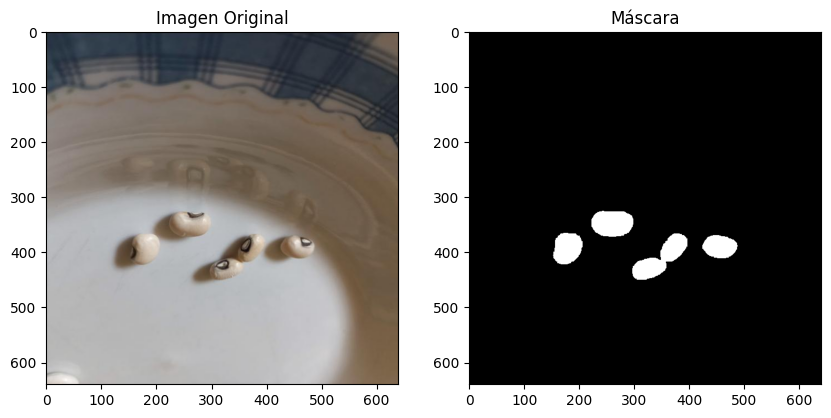

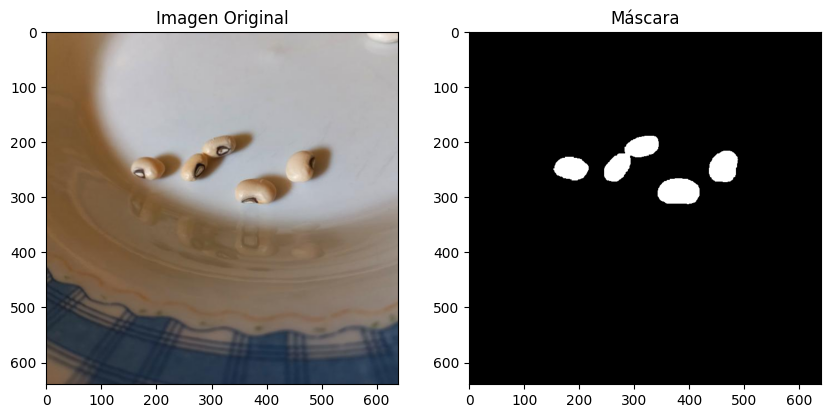

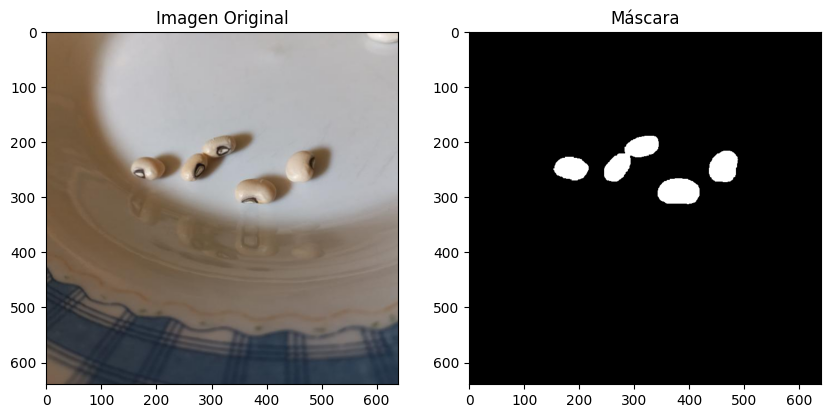

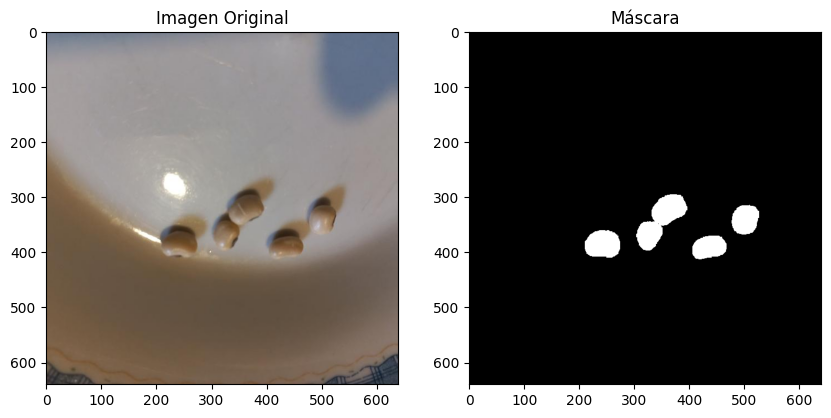

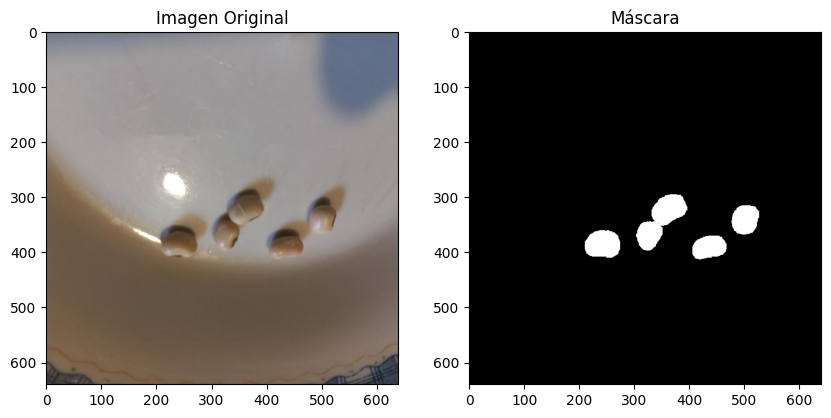

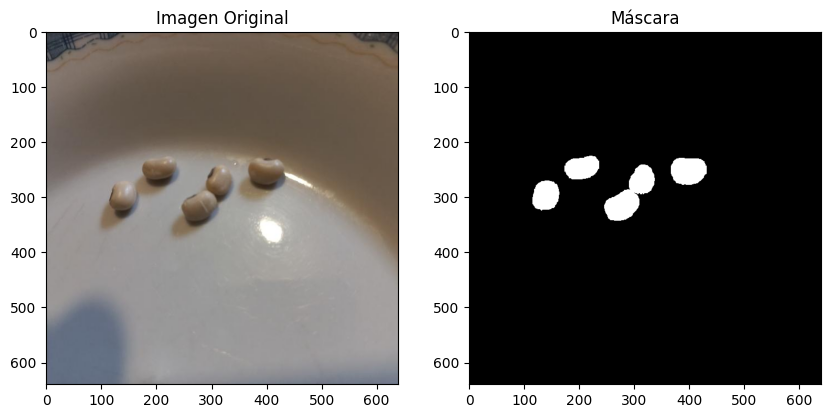

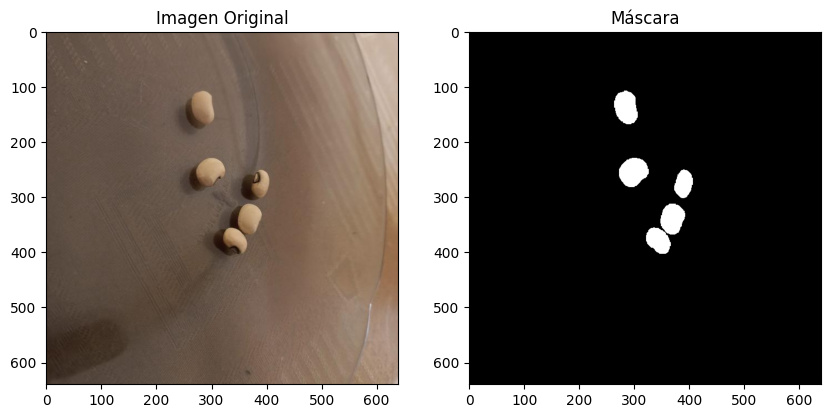

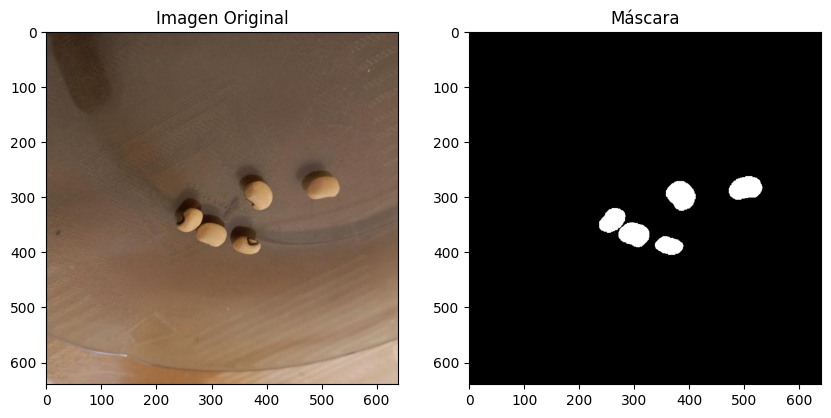

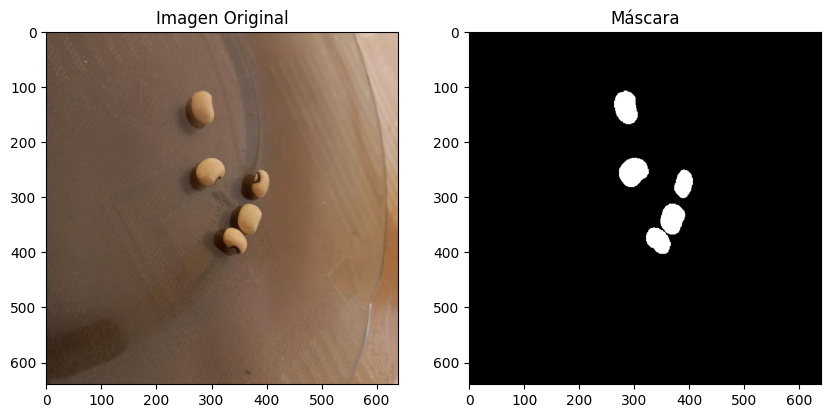

KeyboardInterrupt: ignored

In [10]:
from PIL import Image
import os
import matplotlib.pyplot as plt

def show_images_side_by_side(image_folder, mask_folder):
    # Obtén la lista de archivos en ambas carpetas
    image_files = os.listdir(image_folder)
    mask_files = os.listdir(mask_folder)

    # Ordena la lista para asegurar que coincidan las imágenes y las máscaras
    image_files.sort()
    mask_files.sort()
    count = 0
    # Itera sobre los archivos y muestra las imágenes lado a lado
    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_folder, image_file)
        mask_path = os.path.join(mask_folder, mask_file)

        # Abre las imágenes
        image = Image.open(image_path)
        mask = Image.open(mask_path)

        # Crea una figura y muestra las imágenes lado a lado
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Imagen original
        axes[0].imshow(image)
        axes[0].set_title('Imagen Original')

        # Máscara
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Máscara')
        if count == 3:
          break;
        count =+1
        plt.show()

# Rutas de las carpetas de imágenes y máscaras
carpeta_imagenes = "/content/Dataset_coco_last/train/images"
carpeta_masks = "/content/Dataset_coco_last/train/mask"

# Llamada a la función para mostrar imágenes y máscaras lado a lado
show_images_side_by_side(carpeta_imagenes, carpeta_masks)

In [11]:
import torch
dataloader = {
    'train': torch.utils.data.DataLoader(data_train, batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(data_test, batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 640, 640]), torch.Size([16, 3, 640, 640]))

In [12]:

imgs, mask = next(iter(dataloader['train']))
print('Forma Xi:',imgs.shape,'|',mask.shape)

Forma Xi: torch.Size([16, 3, 640, 640]) | torch.Size([16, 3, 640, 640])


In [13]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

# ***Unet MODEL***

In [14]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

# ***Fit***

In [15]:
def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      torch.save(model.state_dict(), f'/content/drive/MyDrive/IA_II/Segmentation/Unet/Weights/{epoch}.pth')
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

# ***Training***

In [16]:
model = UNet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.44973 test_iou 0.49606: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]



Epoch 1/30 loss 0.58368 iou 0.43535 test_loss 0.44973 test_iou 0.49606


test_loss 0.18301 test_iou 0.72751: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]



Epoch 2/30 loss 0.29458 iou 0.56657 test_loss 0.18301 test_iou 0.72751


test_loss 0.09803 test_iou 0.72751: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]



Epoch 3/30 loss 0.13650 iou 0.75003 test_loss 0.09803 test_iou 0.72751


test_loss 0.06932 test_iou 0.72751: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]



Epoch 4/30 loss 0.08222 iou 0.75064 test_loss 0.06932 test_iou 0.72751


test_loss 0.04843 test_iou 0.72751: 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]



Epoch 5/30 loss 0.06004 iou 0.74965 test_loss 0.04843 test_iou 0.72751


test_loss 0.03944 test_iou 0.63883: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]



Epoch 6/30 loss 0.04712 iou 0.65733 test_loss 0.03944 test_iou 0.63883


test_loss 0.03767 test_iou 0.65091: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]



Epoch 7/30 loss 0.03950 iou 0.64574 test_loss 0.03767 test_iou 0.65091


test_loss 0.02907 test_iou 0.67217: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]



Epoch 8/30 loss 0.03380 iou 0.64402 test_loss 0.02907 test_iou 0.67217


test_loss 0.02832 test_iou 0.63112: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]



Epoch 9/30 loss 0.03011 iou 0.64800 test_loss 0.02832 test_iou 0.63112


test_loss 0.02407 test_iou 0.67455: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]



Epoch 10/30 loss 0.02692 iou 0.64458 test_loss 0.02407 test_iou 0.67455


test_loss 0.02319 test_iou 0.61929: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]



Epoch 11/30 loss 0.02460 iou 0.64329 test_loss 0.02319 test_iou 0.61929


test_loss 0.01962 test_iou 0.60480: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]



Epoch 12/30 loss 0.02292 iou 0.64882 test_loss 0.01962 test_iou 0.60480


test_loss 0.01914 test_iou 0.65410: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]



Epoch 13/30 loss 0.02159 iou 0.64320 test_loss 0.01914 test_iou 0.65410


test_loss 0.01750 test_iou 0.65219: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]



Epoch 14/30 loss 0.02003 iou 0.65128 test_loss 0.01750 test_iou 0.65219


test_loss 0.01680 test_iou 0.65481: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]



Epoch 15/30 loss 0.01886 iou 0.65498 test_loss 0.01680 test_iou 0.65481


test_loss 0.01668 test_iou 0.66894: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]



Epoch 16/30 loss 0.01774 iou 0.65708 test_loss 0.01668 test_iou 0.66894


test_loss 0.01763 test_iou 0.66035: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]



Epoch 17/30 loss 0.01720 iou 0.65835 test_loss 0.01763 test_iou 0.66035


test_loss 0.01540 test_iou 0.68344: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]



Epoch 18/30 loss 0.01661 iou 0.65863 test_loss 0.01540 test_iou 0.68344


test_loss 0.01481 test_iou 0.70415: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]



Epoch 19/30 loss 0.01575 iou 0.67288 test_loss 0.01481 test_iou 0.70415


test_loss 0.01491 test_iou 0.70107: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]



Epoch 20/30 loss 0.01523 iou 0.67322 test_loss 0.01491 test_iou 0.70107


test_loss 0.01478 test_iou 0.72666: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]



Epoch 21/30 loss 0.01519 iou 0.66284 test_loss 0.01478 test_iou 0.72666


test_loss 0.01456 test_iou 0.69537: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]



Epoch 22/30 loss 0.01489 iou 0.67120 test_loss 0.01456 test_iou 0.69537


test_loss 0.01503 test_iou 0.70764: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]



Epoch 23/30 loss 0.01442 iou 0.68479 test_loss 0.01503 test_iou 0.70764


test_loss 0.01387 test_iou 0.72107: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]



Epoch 24/30 loss 0.01378 iou 0.68679 test_loss 0.01387 test_iou 0.72107


test_loss 0.01275 test_iou 0.70230: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]



Epoch 25/30 loss 0.01354 iou 0.69087 test_loss 0.01275 test_iou 0.70230


test_loss 0.01327 test_iou 0.72924: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]



Epoch 26/30 loss 0.01314 iou 0.69801 test_loss 0.01327 test_iou 0.72924


test_loss 0.01261 test_iou 0.71428: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]



Epoch 27/30 loss 0.01296 iou 0.69521 test_loss 0.01261 test_iou 0.71428


test_loss 0.01228 test_iou 0.72987: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]



Epoch 28/30 loss 0.01234 iou 0.70719 test_loss 0.01228 test_iou 0.72987


test_loss 0.01253 test_iou 0.72322: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]



Epoch 29/30 loss 0.01222 iou 0.70816 test_loss 0.01253 test_iou 0.72322


test_loss 0.01247 test_iou 0.74317: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 30/30 loss 0.01192 iou 0.71550 test_loss 0.01247 test_iou 0.74317


# ***TESTING***

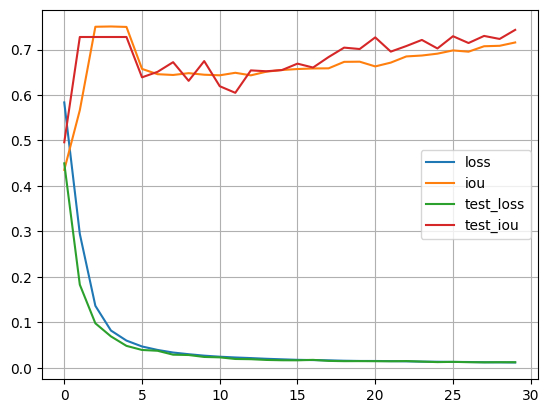

In [17]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [20]:
imgs = [Image.open(f"/content/Dataset_coco_last/test/images/{i}") for i in os.listdir(f"/content/Dataset_coco_last/test/images")]
masks = [Image.open(f"/content/Dataset_coco_last/test/mask/{i[:-4]}.png") for i in os.listdir(f"/content/Dataset_coco_last/test/images")]
len = len(imgs)
idx= random.randint(0,len-1)
mask = np.array(masks[idx])

(3, 640, 640)
torch.Size([3, 640, 640])


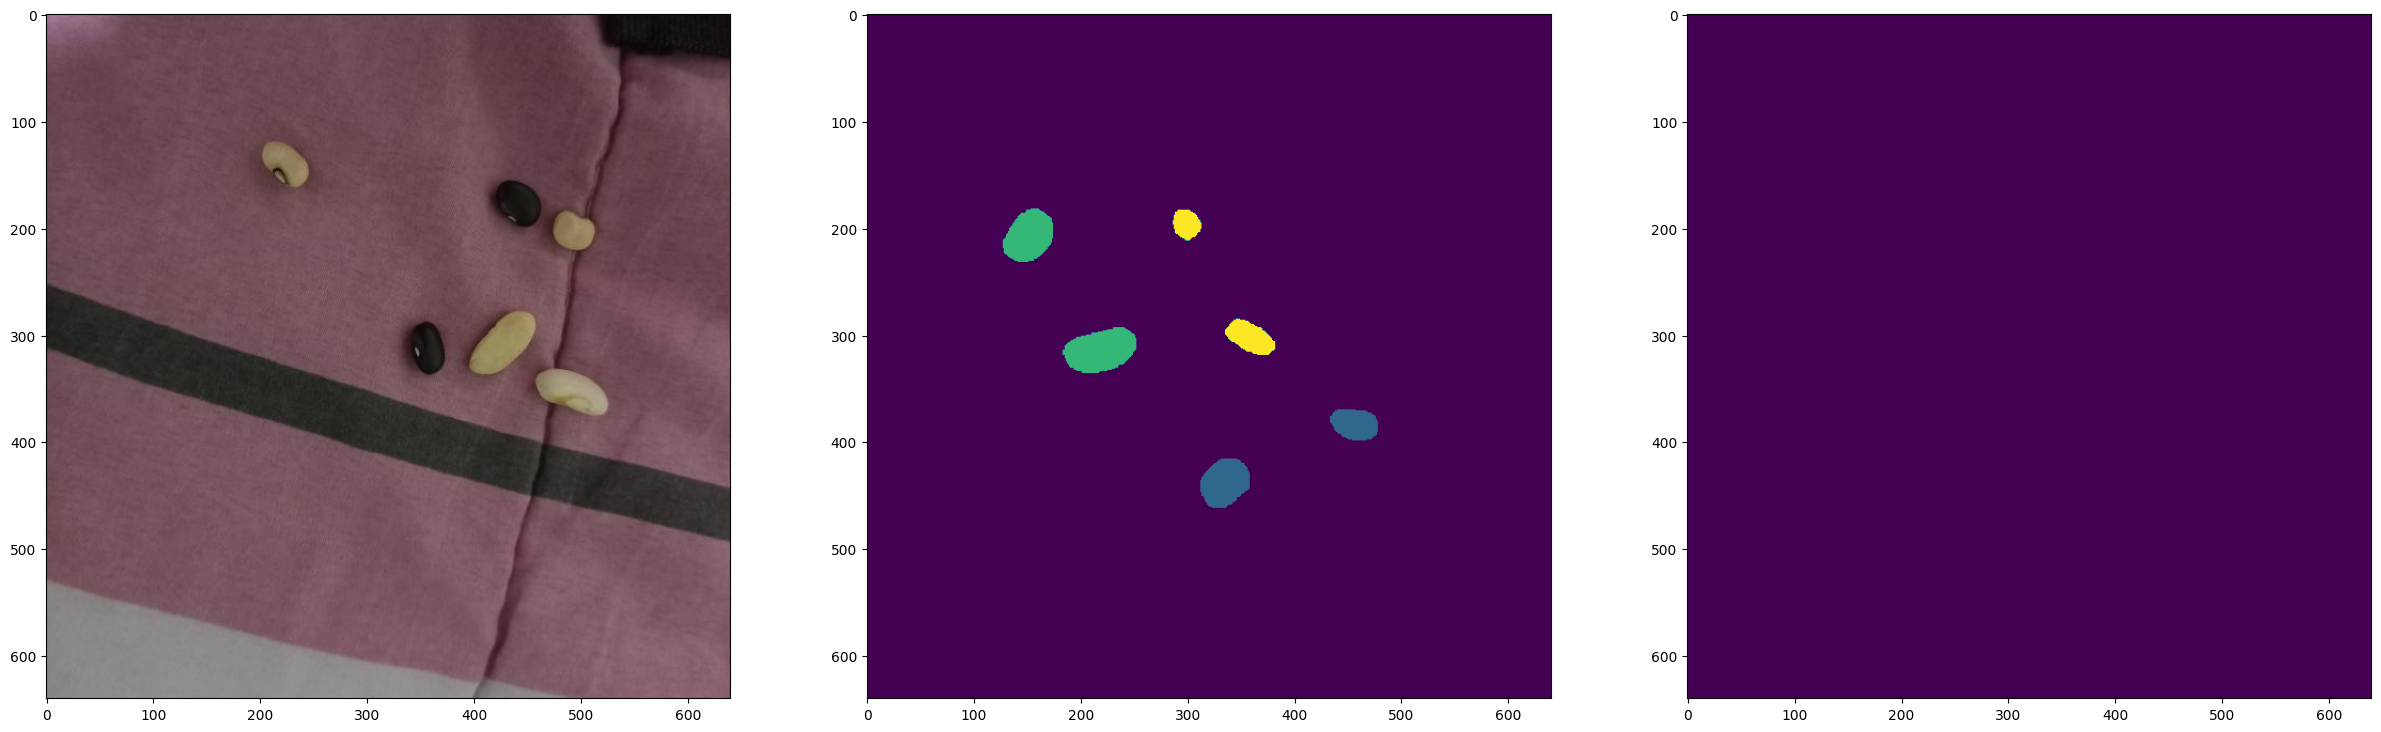

In [26]:
import torch
model.eval()
with torch.no_grad():
    ix = 20
    img, mask_oh = data_test[ix]
    output = model(torch.from_numpy(img).unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
print(img.shape)
print(output.shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(torch.from_numpy(img).permute(1,2,0))
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()